# Notities

Hier worden stukjes code bewaard uit de beoordelings notebook.

<hr>

## Introductie

Een veelgebruikt criterium voor modelbeoordeling is de ‘fit’, die vaak wordt uitgedrukt met de afkorting EVP, wat staat voor het "Explained Variance Percentage". Hiermee wordt uitgedrukt hoe goed de simulatie op de metingen lijkt. Het notebook laat zien in hoeverre deze ‘fit’ een goede indicatie is voor de voorspellende waarde van het model.

Het notebook behandelt de meest gebruikte statistische toetsen. Speciale aandacht wordt besteed aan het kwantificeren van de betrouwbaarheid van de modelparameters. Welke voorwaarden zijn daarvoor vereist om dit te kunnen doen? Hoe kan je het model aanpassen zodat je aan de vereiste statistische voorwaarden voldoet?

De eenvoudigste methode voor de beoordeling van een tijdreeksmodel is een visuele beoordeling. Ook kunnen er diverse statistieken berekend worden voor een geoptimaliseerd tijdreeksmodel. Aan de hand van een stijghoogtereeks uit de praktijk worden deze methodes toegelicht. Voor de berekende statistieken uitgelegd wat de getallen betekenen en hoe deze gebruikt kunnen worden.

<p style="color:red">%% DB: Ik heb wat tekst aanpassingen gedaan. Introductie kan nog wat duidelijker als de inhoud van het notebook compleet is denk ik. %%</p>

%% 
voorbeelden toevoegen van:
- Model met hoge EVP met grote onzekerheid in parameter (plaatje hieronder maken in notebook?). Hiermee laten zien waarom 2x standaarddeviatie belangrijk is.
- Modellen met hoge correlatie tussen 2 parameters (eentje aanpassen en vastzetten dan zien dat de fit goed blijft?). Makkelijkst met een recharge factor.
- Model wat door alle diagnostische toetsen heenkomt.

Nog doen
- waar dubbele procent-tekens staan (%%) moet nog iets gebeuren 
- Meer referenties opnemen, oa statistieken fit paper van Raoul
- model nemen wat door alle toetsen heenkomt (met gelijke tijdstappen), mogelijk basic model van bpastas
- Kijk naar woorden als vaak en regelmatig en vermijdt deze
- Model met goede evp en slechte fit openmen
- hoofdstuk toevoegen -> hydrologische beoordeling:
    - bij een onttrekking gws omlaag
    - verdampingsfactor
    - geheugen
    - ruimtelijke beoordeling (resultaten t.o.v. andere buizen in de omgeving), pastas artikel verwijzing
    - frequency of exceedance

%%
Een tijdreeksmodel kan op een aantal onderdelen beoordeelt worden. In dit notebook komen de volgende onderwerpen aan bod:

<hr>

## Voorbeeld tijdreeksmodel <a name="tijdreeksmodel"></a>

In dit notebook maken we gebruik van een simpel tijdreeksmodel om de grondwaterstand te simuleren met neerslag en verdamping als verklarende variabelen. De tijdreeksen van de grondwaterstand, neerslag en verdamping zijn hieronder weergegeven.

In [22]:
# inlezen tijdreeksen
oseries = pd.read_csv("data/grondwaterstand.csv",
                      parse_dates=True,  squeeze=True, index_col=0)

neerslag = pd.read_csv("data/neerslag.csv", parse_dates=True,
                       squeeze=True, index_col=0)

verdamping = pd.read_csv("data/verdamping.csv", parse_dates=True,
                         squeeze=True, index_col=0)

Text(0.5, 6.0, ' ')

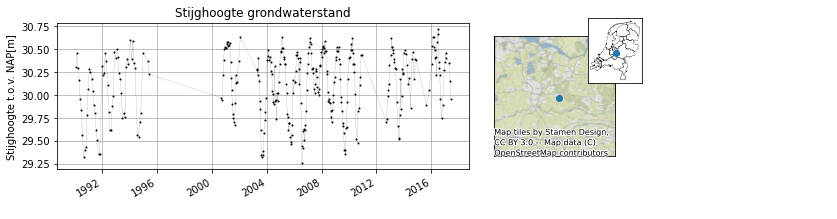

In [41]:
# %% Invullen coordinaten peilbuis 101
x = 150000.
y = 450000.

fig = plt.figure(figsize=(10, 3))

gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])

ax2.set_xticks([])
ax2.set_yticks([])
ax3 = plt.axes([0.85, 0.60, 0.1, 0.3])
ax3.set_xticks([])
ax3.set_yticks([])

ax2.plot(x, y, marker="o")
ax3.plot(x, y, marker="o")

# plot provincies
fname = ('data/2018-Imergis_provinciegrenzen_kustlijn-shp'
         '/2018-Imergis_provinciegrenzen_kustlijn.shp')
provincies = gpd.read_file(fname).set_index('provincien')
provincies.plot(ax=ax3, facecolor="none", edgecolor="k", lw=0.25)

i = 30000
ax2.set_xlim(x - i, x + i)
ax2.set_ylim(y - i, y + i)

ctx.add_basemap(ax2, reset_extent=False, crs=pyproj.Proj("epsg:28992").srs)

oseries.plot(ax=ax1, marker=".", color="k", linestyle="-", lw=0.1, markersize=2)
ax1.grid()

ax1.set_title("Stijghoogte grondwaterstand")
ax1.set_ylabel("Stijghoogte t.o.v. NAP[m]")
ax1.set_xlabel(" ")
# fig.tight_layout()

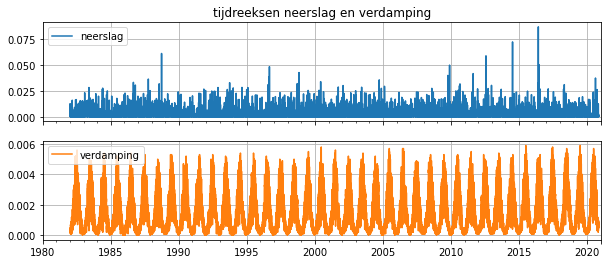

In [43]:
# laat de verklarende tijdreeksen zien in een figuur
fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(10, 4), sharex=True)

neerslag.plot(ax=ax1, label='neerslag')
verdamping.plot(ax=ax2, label='verdamping', color="C1")

for ax in [ax1, ax2]:
    ax.set_xlim(dt.datetime(1980, 1, 1), dt.datetime(2021, 1, 1))
    ax.legend(loc="upper left")
    ax.grid()
ax1.set_title('tijdreeksen neerslag en verdamping');

In [45]:
# maken tijdreeksmodel
ml = ps.Model(oseries)
sm1 = ps.StressModel(neerslag, rfunc=ps.Gamma, name="neerslag")
# let op: up=False omdat positieve verdamping de grondwaterstand verlaagd
sm2 = ps.StressModel(verdamping, rfunc=ps.Gamma, name="verdamping", up=False)
ml.add_stressmodel([sm1, sm2])

In [46]:
# optimaliseer model
ml.solve(report=False)

<hr>

### Model diagnostiek

De berekende standaarddeviaties zijn betrouwbaar als aan een aantal voorwaarden wordt voldaan. De twee voorwaarden voor de met het ruismodel berekende ruis zijn dat het:
1. zich gedraagt als witte ruis met een gemiddelde van nul.
2. niet gecorreleerd is aan een verklarende tijdreeks.

Er is sprake van witte ruis wanneer:
1. er geen significante autocorrelatie in de ruis aanwezig is
2. de ruis homoscedastisch is
3. de ruis voldoet aan een, bij voorkeur normale, statistische verdeling.

Het is aan te bevelen om te checken of aan deze voorwaarden wordt voldaan wanneer gebruik wordt gemaakt van de standaarddeviaties van de parameters. De voorwaarden voor de ruis kunnen gecheckt worden via een aantal statistische toetsen. Deze test worden meestal uitgevoerd met een nulhypothese ($H_0$) en een alternatieve hypothese ($H_A$):

- $H_0$: de ruis is onafhankelijk, homoscedastisch of normaal verdeeld
- $H_A$: de ruis is niet onafhankelijk, homoscedastisch, of normaal verdeeld

Voor een hypothese toets wordt een bepaalde statistische waarde berekend (bijv. $Q_{test}$), die vervolgens wordt vergeleken met een theoretische waarde op basis van een bepaalde verdeling (bijv. $\chi^2_{\alpha, h}$) die afhankelijk is van een significantieniveau (bijv. $\alpha=0.05$) en soms afhankelijk is van het aantal vrijheidsgraden $h$. Het resultaat is het wel of niet verwerpen van de nulhypothese. Dit resultaat kan nooit gebruikt worden om de alternatieve hypothese te accepteren. Wanneer bij de test voor autocorelatie de nulhypothese niet verworpen wordt kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de ruis maar we kunnen niet concluderen dat er geen autocorrelatie is.

In deze paragraaf worden de 3 voorwaarden voor witte ruis en de daarbij horende statistische toesten verder toegelicht.

%% 
Nog wat vragen:
- waarom twee testen voor normale verdeling en autocorelatie? Wat als de ene wel door de test komt en de ander niet?
- Klopt het dat dit alle voorwaarden zijn voor witte ruis?
- klopt het wel wat ik zeg over het accepteren van de nulhypothese maar het niet verwerpen van de alternatieve hypothese?
%%

#### Autocorrelatie

Het kan gebeuren dat een tijdreeks gecorreleerd is met een in de tijd verschoven versie van zichzelf. Als dat het geval is spreken we van autocorrelatie. De autocorrelatie kan worden weergegeven in een autocorrelatiediagram zoals hieronder. Hierin is op de x-as de verschuiving in de tijd weergegeven (lag) en op de y-as de hierbij berekende correlatie. De autocorrelatie wordt weergegeven tot een maximale verschuiving van 1 jaar (365 dagen). De blauwe band in de grafiek geeft het 95% betrouwbaarheidsinterval weer. Wanneer 95% van de berekende autocorrelaties binnen dit interval liggen kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de reeks.



%% Vragen:
- Als het betrouwbaarheidsinterval wordt berekend op basis van de autocorrelaties en je vervolgens gaat toetsen of de autocorrelaties binnen dit betrouwbaarheidsinterval liggen dan komt deze altijd door de toets toch? Of maak ik nu een denkfout? Waar wordt de blauwe band mee berekend?
- dit model komt niet door de Runs test, enig idee waarom niet?
%%

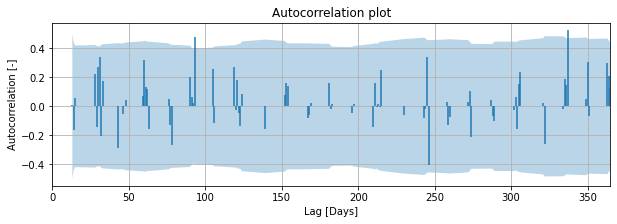

In [43]:
ax = ps.stats.plot_acf(ml.noise(), acf_options={"max_gap": 60, "min_obs": 24},
                       figsize=(10, 3), alpha=0.01)



Naas de visuele check op autocorrelatie bestaan er ook statische toestsen om te checken of er autocorrelatie aanwezig is. Deze zijn in onderstaande tabel weergegeven. De eerste twee methodes `ljung_box` en `Durbin-Watson` zijn alleen geschikt voor equidistante tijdreeksen. In tijdreeksen van grondwaterstanden missen vaak metingen en dus zijn deze niet equidistant. Voor het checken van autocorrelatie worden daarom meestal de `Stoffer-Toloi` en de `Runs Test` gebruikt die wel kunnen omgaan met niet equidistante reeksen.


| Naam | Beschrijving | geschikt voor niet equidistante reeksen |
|:-----|:-----------------------------------------|:---------------:|
| Ljung-Box test| Deze test checkt of de autocorrelatie in een tijdreeks significant verschilt van nul| Nee |
| Durbin-Watson test | Deze test checkt de autocorrelatie bij een verschuiving van één tijdstap. | Nee |
| Stoffer-Toloi test | Deze test is vergelijkbaar met de Ljung-Box test, maar aangepast voor missende waarde | Ja |
| Runs test | Deze test checkt of de waarden in een tijdreeks willekeurig zijn zonder uit te gaan van een bepaalde kansverdeling. | Ja |


<p style="color:red">%% Hoe zit het met Stoffer-Toloi? Hoeveel data mag er missen? Kan je ook bij een frequentie waar soms iets mist toch deze test doen?%%</p>

In [44]:
alpha = 0.05

stat, p = ps.stats.stoffer_toloi(ml.noise(), lags=15, freq="D")

print("Stoffer-Toloi test:")
if p > alpha:
    print(
        "Nullhypothese niet verworpen, geen significante autocorrelatie. p =",
        p.round(2),
    )
else:
    print("Nullhypothese verworpen")


print("\nRuns test:")
stat, p = ps.stats.runs_test(ml.noise())

if p > alpha:
    print(
        "Failed to reject the Null-hypothesis, no significant autocorrelation. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis")

Stoffer-Toloi test:
Nullhypothese verworpen

Runs test:
Reject the Null-hypothesis


#### Homoscedasticiteit

Een reeks is homoscedastisch als alle waarden dezelfde eindige variantie hebben. Bij ons tijdreeksmodel betekent dit dat de ruis onafhankelijk is van de gemeten grondwaterstanden. Dit is hieronder visueel weergegeven door deze waarden tegen elkaar uit te zetten in een grafiek.

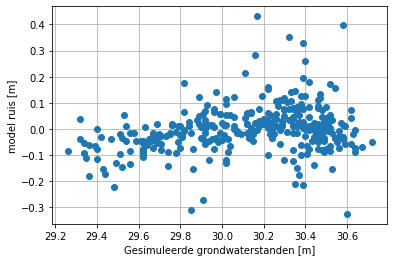

In [45]:
plt.plot(ml.observations(), ml.noise(), marker="o", linestyle=" ")
plt.xlabel("Gesimuleerde grondwaterstanden [m]")
plt.ylabel("model ruis [m]")
plt.grid()

Er bestaan verschillende statistische toetsen om te checken of een reeks homoscedastisch is.

| Naam | Beschrijving | geschikt voor niet equidistante reeksen |
|:-----|:----------------------------------|----------------:|
|Engle test| |Onbekend|
|Breusch-Pagaan test| niet beschikbaar | |Onbekend|

<p style="color:red">%% Gaan we hier nog iets mee doen? %%</p>

#### Normale verdeling

Een veelgebruikte aanname is dat de ruis normaal verdeeld is. In principe is het ook mogelijk er een andere kansverdeling bij de ruis hoort. De verdeling van de ruis kan weergegeven worden met een histogram in combinatie met een kansverdeling. 

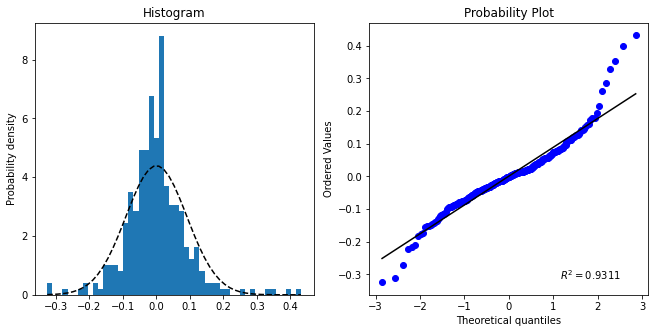

In [46]:
# Plot the histogram for normality and add a 'best fit' line
bins = 50
series = ml.noise()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5))
_, bins, _ = ax1.hist(series.values, bins=bins, density=True)
y = norm.pdf(bins, series.mean(), series.std())
ax1.plot(bins, y, "k--")
ax1.set_ylabel("Probability density")
ax1.set_title("Histogram")

# Plot the probability plot
probplot(series, plot=ax2, dist="norm", rvalue=True)
ax2.get_lines()[0].set_color("b")
ax2.get_lines()[1].set_color("k")

Het is een beruchte uitdaging om te bepalen of een tijdreeks normaal verdeeld is. Er bestaan wel testen maar deze zijn niet altijd betrouwbaar. Aan de ene kant geldt dat als er weinig metingen beschikbaar zijn, de afwijkingen van een normale verdeling erg sterk moeten zijn voordat de test ze kan detecteren. Aan de andere kant geldt dat bij een groot aantal metingen, hele kleine (irrelevante) afwijkingen van de normale verdeling al tot significante uitkomsten leiden.  Het is daarom lastig objectief vast te stellen of ruis normaal verdeeld is.

| Naam | Beschrijving | Geschikt voor niet equidistante tijdreeksen? |
|:-----|:------------|----------------:|
| Shapiro-Wilk | Deze test checkt of de data uit een normale verdeling is getrokken | Onbekend |
| D'Agostino | Deze test checkt of de ruis voldoet aan een normale verdeling (H0 hypothesis). | Onbekend |


%% vragen:
- werken deze testen voor niet equidistante tijdreeksen?
- waarom zijn de p-waarden zo klein bij kleine tijdstappen? Tijdstap van 70 dagen lukt het wel, gevoelsmatig wel weer heel groot.
%%

In [47]:
stat, p = shapiro(ml.noise())

print("Shapiro-Wilk test:")
if p > alpha:
    print(
        "Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =",
        np.round(p, 2),
    )
else:
    print("Reject the Null-hypothesis. p =", np.round(p, 3))


stat, p = normaltest(ml.noise())

print("\nD'Agostino test:")
if p > alpha:
    print(
        "Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(3))

Shapiro-Wilk test:
Reject the Null-hypothesis. p = 0.0

D'Agostino test:
Reject the Null-hypothesis. p = 0.0


#### Overzicht visuele en diagnostische toetsen

In [48]:
# diagnostische toetsen voor het model
ml_simple.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.95,0.00,True
D'Agostino,Normality,34.11,0.00,True
Runs test,Autocorr.,-2.62,0.01,True
Stoffer-Toloi,Autocorr.,11.55,0.64,False


/home/david/Github/pastas/pastas/stats/tests.py:616: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")


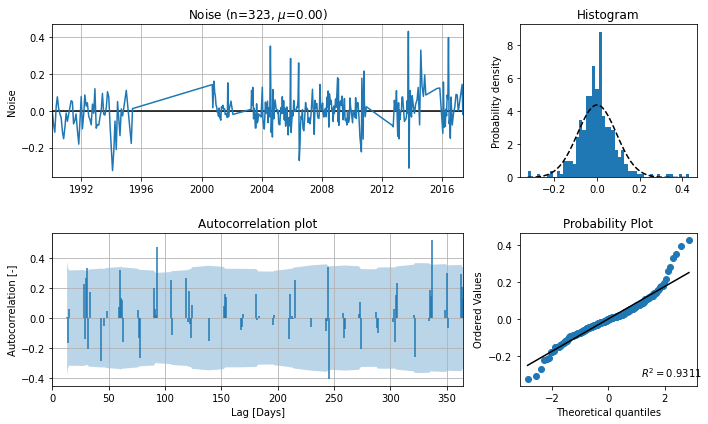

In [49]:
# visualisatie diagnostische toetsen
ml.plots.diagnostics(acf_options={"max_gap": 60, "min_obs": 24});

<hr>

#### Overzicht visuele en diagnostische toetsen

In [ ]:
# diagnostische toetsen voor het model
ml_simple.stats.diagnostics(alpha=0.05)

In [ ]:
# visualisatie diagnostische toetsen
ml.plots.diagnostics(acf_options={"max_gap": 60, "min_obs": 24});

<hr>

### Overfitting

Wanneer er meer verklarende variabelen, en bijbehorende modelparameters, aan een tijdreeksmodel worden toegevoegd is de fit over het algemeen beter. Dit is zelfs het geval als de grondwaterstanden niet worden beïnvloed door de verklarende variabele. Immers, hoe meer vrijheidsgraden (parameters) het model heeft des te makkelijker het model op de metingen kan worden gefit. Maar als zo'n verklarende variabele (die er eigenlijk niet toe doet) wordt toegevoegd verbetert de voorspellende waarde van het model niet. Het fenomeen waarbij meer parameters worden toegevoegd aan het model dan gerechtvaardigd op basis van de metingen heet overfitting. 

Het is dus niet mogelijk om op basis van enkel de fit statistieken aan te geven of het model verbetert na het toevoegen van een verklarende variabele. Twee statistieken die wel rekening houden met overfitting zijn:

- **aic**: Akaike information criterion
- **bic**: Bayesian information criterion

Zowel de `aic` als de `bic` zijn een maat voor de relatieve hoeveelheid informatie die verloren is gegaan in het model. Het zijn dus relatieve waarde en kunnen het best gebruikt worden om verschillende modellen voor dezelfde meetreeks met elkaar te vergelijken. Wanneer de `aic` en `bic` lager worden na het toevoegen van een verklarende variabele betekent dit dat het model verbetert (er gaat relatief minder informatie verloren). Als de aic en bic hoger worden dan heeft het toevoegen van de parameters niet bijgedragen aan een verbetering van het model.

In het voorbeeld hieronder is het eerste model vereenvoudigd door de neerslag en de verdamping samen te nemen als een verklarende reeks. 

Eerst zijn de `evp`, `aic` en `bic` van het eerste voorbeeld model gepresenteerd. In dat model zijn de neerslag en de verdamping als twee losse verklarende variabelen opgegeven waarbij voor beide invloeden 3 parameters worden toegevoegd aan het model.

%% aic en bic moeten op de noise worden uitgerekend mits de noise ongecorreleerd is %%

In [14]:
# evp, aic en bic huidig model met neerslag en verdamping als verklarende variabelen
print(f'Explained variance percentage (evp)  : {ml.stats.evp():.2f}%')
print(f'R-squared (rsq)                      : {ml.stats.rsq():.2f}')
print(f'Akaike information criterion (aic)   : {ml.stats.aic():.2f}')
print(f'Bayesian information criterion (bic) : {ml.stats.bic():.2f}')

Explained variance percentage (evp)  : 89.25%
R-squared (rsq)                      : 0.89
Akaike information criterion (aic)   : 13.14
Bayesian information criterion (bic) : 43.36


Het is kan worden vereenvoudig door de grondwateraanvulling (het verschil tussen neerslag en verdamping) als verklarende reeks toe te passen. Als de statistieken opnieuw berekend worden voor dit model is duidelijk dat de fit iets minder goed is geworden (van 89% naar 87%) maar de `aic` en `bic` zijn lager. Als er een model geselecteerd moet worden, dan gaat de voorkeur uit naar het model met de laagste `aic`. Met andere woorden, de extra parameters in het eerste model leveren dus niet voldoende verbetering op in de fit om toevoeging van de parameters te ondersteunen. De `aic` valt daarom hoger uit ten opzichte van het vereenvoudigde model. 

<p style="color:red">%% We hebben ook voorbeelden waarbij een aanzienlijke verbetering in fit na toevoegen van een invloed, de AIC alsnog hoger uitvalt..., dus wat moeten we daarmee? Zie bijvoorbeeld het model met en zonder rivier in "adding_rivers.ipynb".%%</p>

In [15]:
# maken tijdreeksmodel met grondwateraanvulling (= neerslag - verdamping)
ml_simple = ps.Model(oseries)
sm = ps.StressModel(neerslag - verdamping, rfunc=ps.Gamma, name="gw_aanvulling")
ml_simple.add_stressmodel(sm)
ml_simple.solve(report=False)

In [16]:
# evp, aic en bic model
print(f'Explained variance percentage  : {ml_simple.stats.evp():.2f}%')
print(f'R-squared (rsq)                : {ml_simple.stats.rsq():.2f}')
print(f'Akaike information criterion   : {ml_simple.stats.aic():.2f}')
print(f'Bayesian information criterion : {ml_simple.stats.bic():.2f}')

Explained variance percentage  : 87.18%
R-squared (rsq)                : 0.87
Akaike information criterion   : 6.79
Bayesian information criterion : 25.68


In [17]:
# in pastas kan je een overzicht krijgen van alle fit statistieken
ml.stats.summary()

,Value
Statistic,
rmse,0.113815
rmsn,0.090891
sse,4.171305
mae,0.084914
nse,0.892459
evp,89.249388
rsq,0.892551
bic,43.364761
aic,13.143542


Het is aan te bevelen om te checken of aan deze voorwaarden wordt voldaan wanneer gebruik wordt gemaakt van de standaarddeviaties van de parameters. De voorwaarden voor de ruis kunnen gecheckt worden via een aantal statistische toetsen. Deze test worden meestal uitgevoerd met een nulhypothese ($H_0$) en een alternatieve hypothese ($H_A$):

- $H_0$: de ruis is onafhankelijk, homoscedastisch of normaal verdeeld
- $H_A$: de ruis is niet onafhankelijk, homoscedastisch, of normaal verdeeld

Voor een hypothese toets wordt een bepaalde statistische waarde berekend (bijv. $Q_{test}$), die vervolgens wordt vergeleken met een theoretische waarde op basis van een bepaalde verdeling (bijv. $\chi^2_{\alpha, h}$) die afhankelijk is van een significantieniveau (bijv. $\alpha=0.05$) en soms afhankelijk is van het aantal vrijheidsgraden $h$. Het resultaat is het wel of niet verwerpen van de nulhypothese. Dit resultaat kan nooit gebruikt worden om de alternatieve hypothese te accepteren. 

Wanneer bij de test voor autocorelatie de nulhypothese niet verworpen wordt kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de ruis maar we kunnen niet concluderen dat er geen autocorrelatie is.

%% 
Nog wat vragen:
- waarom twee testen voor normale verdeling en autocorelatie? Wat als de ene wel door de test komt en de ander niet?
- Klopt het dat dit alle voorwaarden zijn voor witte ruis?
- klopt het wel wat ik zeg over het accepteren van de nulhypothese maar het niet verwerpen van de alternatieve hypothese?
%%

<hr>

**voorbeeld parameter correlaties**<br>
Hieronder is de correlatiematrix weergegeven van de parameters in het model met neerslag en verdamping als losse verklarende variabelen waarbij alleen correlaties hoger dan 0.5 of kleiner dan -0.5 zijn weergegeven.

In [ ]:
# correlatiecoëfficiënten > +/-0.5 (rho)
pcor = ml1.fit.pcor.copy()
pcor[pcor.abs() < 0.5] = np.nan
pcor.style.applymap(cbg).applymap(ctxt).set_precision(
    2).highlight_null(null_color='lightgray')

Parameters met een sterke positieve of negatieve correlatie gevan aan dat een aanpassing in een parameter gecompenseerd kan worden met aanpassingen aan de gecorreleerde parameters terwijl de fit van het model vergelijkbaar blijft. Er zijn dus meerdere parameter combinaties die een model met een goede fit opleveren. 

De parameter `verdamping_A` is bijvoorbeeld sterk negatief gecorreleerd met `verdamping_a`. In het voorbeeld hieronder wordt parameter `verdamping_A` aangepast, door het met een factor 5 te vermenigvuldigen. Als het model opnieuw geoptimaliseerd wordt terwijl de waarde voor `verdamping_A` vast staat, levert dat een model met een vergelijkbare fit op. De aanpassing van deze `verdamping_A` is gecompenseerd via de andere sterk gecorreleerde parameters.

In [ ]:
# voorbeeld uitwerken wanneer correlatie een 'probleem' is

# plot modelresultaat
ax = ml.plot(figsize=(14, 4))
# sla oorspronkelijke optimale parameters op
optparams1 = ml.parameters.optimal.copy()

# aanpassen sterk gecorreleerde parameter en vastzetten in optimalisatie
verdamping_A = ml.parameters.loc["verdamping_A", "optimal"]
ml.set_parameter("verdamping_A", initial=verdamping_A*5, vary=False)
ml.solve(report=False)

# opslaan nieuwe optimale parameters
optparams2 = ml.parameters.optimal.copy()

# plot nieuwe resultaat
ml.plot(ax=ax)
ax.legend(ncol=2)
ax.set_title("Vergelijking modellen na aanpassing sterk gecorreleerde parameter")

# vastzetten parameter weer ongedaan maken
ml.set_parameter("verdamping_A", vary=True)
ml.solve(report=False)

De optimale parameters zijn hieronder weergegeven voor het oorspronkelijke model en het model waarbij `verdamping_A` is aangepast en vastgezet. Het is duidelijk te zien dat de aanpassing in `verdamping_A` is gecompenseerd door de overige parameters aan te passen. De grootste veranderingen zijn in de parameters die sterk gecorreleerd waren met `verdamping_A`; de waarde van `verdamping_a` is een factor 10 groter en `verdamping_n` is ongeveer gehalveerd.

In [ ]:
# vergelijking parameter sets van modellen met vergelijkbare fit
df = pd.concat([optparams1, optparams2], axis=1)
df.columns = ["oorspronkelijk", "aanpassing param"]
df["factor verandering"] = df.iloc[:, 1] / df.iloc[:, 0]
df

<hr>

voorbeeld geheugen #2

In [ ]:
# # code om model te genereren
# import hydropandas as hpd
# o = hpd.GroundwaterObs.from_dino(location='B52C0508', filternr=2)['2013-1-1':'2014-7-1']
# knmi_oc = hpd.ObsCollection.from_knmi(xmid=[o.x], ymid=[o.y],
#                                       meteo_vars=('RD', 'EV24'),
#                                       start=[o.index.min(), o.index.min()],
#                                       end=[o.index.max(),o.index.max()],
#                                       cache=True,
#                                       verbose=True)
# knmi_oc
# ml_B52C0508 = ps.Model(oseries=o['stand_m_tov_nap'])
# sm = ps.StressModel(knmi_oc.iloc[0]['obs']['RD'] - knmi_oc.iloc[1]['obs']['EV24'],
#                     rfunc=ps.Gamma, name="recharge")
# ml_B52C0508.add_stressmodel(sm)
# ml_B52C0508.solve()
# ml_B52C0508.to_file(r'data\voorbeeld_geheugen.pas')

## Fit report pastas<a name="fitreport"></a>

<p style="color:red">%% DB: Pastas specifiek ...? </p> 

Een groot deel van de hierboven besproken tools voor het beoordelen van een model worden in pastas automatisch getoond na het optimaliseren van een tijdreeksmodel met `ml.solve()`. Dit zogenaamde fit rapport geeft een overzicht van de resultaten van de optimalisatie. Het rapport bestaat uit 4 onderdelen:
- Algemene modelinstellingen (linksboven)
- Fit statistieken (rechtsboven)
- Parameters (midden)
- Parameter correlaties (onder)

Hieronder is een fit rapport weergegeven, daaronder is per onderdeel aangegeven welke resultaten worden getoond.

In [ ]:
ml.solve(tmin='1990')

**Algemene modelinstellingen**<br>
Hier worden een aantal instellingen en resultaten genoemd van het model. Dit zijn:
- `nfev`: Het aantal model simulaties dat is uitgevoerd door het optimalisatie-algoritme voordat de optimale parameters zijn gevonden. Wanneer de optimale oplossing niet gevonden kan worden en het maximaal aantal functie-evaluaties is berijkt wordt een waarschuwing gegeven.
- `nobs`: Het aantal metingen dat is gebruikt om de model simulatie te fitten op de metingen. In ons geval is dat het aantal metingen in `oseries1`.
- `noise`: parameters om aan te geven of het noise model is gebruikt bij de optimalisatie. Meer informatie over het noisemodel is hier te vinden %%REFERENTIE%%
- `tmin` and `tmax`: de start en de eindtijd van de metingen die gebruikt worden om het model te optimaliseren. Deze kunnen worden opgegeven in de `ml.solve()` functie. Standaard wordt de start- en eindtijd van de `oseries` gebruikt. In dit geval is aangegeven dat als starttijd 1 januari 1990 gebruikt moet worden.
- `freq`: de frequentie van het tijdreeksmodel. Standaard wordt een dagelijkse frequentie gebruikt %%KLOPT DIT????%%. Dit betekent dat de gesimuleerde en gemeten waarde op dagbasis worden vergeleken indien er metingen beschikbaar zijn op een dag.
- `warmup`: De inlooptijd van het model. De grondwaterstanden op een bepaalde dag hangen af van de externe invloeden (stresses) over een bepaalde periode voor deze dag. We weten de lengte van deze periode niet. Standaard wordt een inlooptijd van 10 jaar min de starttijd `tmin` van het model gebruikt.
- `solver`: Het optimalisatie-algoritme dat wordt gebruikt om de gesimuleerde grondwaterstanden te fitten op de gemeten grondwaterstanden. Met de standaard instellingen wordt gebruikt gemaakt van de [`least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) solver uit de `scipy` package.

**Fit statistics**<br>
Rechtsboven in het model rapport
Deze statistieken geven informatie over de fit tussen gesimuleerde en gemeten grondwaterstanden. De volgende fit parameters worden getoond: 
- `EVP`: Explained variance ook wel bekend als de Nash Sutcliffe coëfficiënt. Een waarde van 100% betekent dat de gemodelleerde en gesimuleerde grondwaterstanden volledige overeenkomen. In de praktijk komt dat niet voor. Meestal wordt een fit hoger dan 60-80% acceptabel geacht om de modelresultaten verder te gebruiken.
- `R2`: the $R^2$ waarde wordt ook wel de determinatiecoëfficiënt genoemd. Een waarde van 1 staat voor een optimale fit.
- `RMSE`: de root mean squared error. Een waarde van 0 staat voor een optimale fit. 
- `AIC`: the Aikake Information Criterion.
- `BIC`: the Bayesan Information Criterion. 

**Parameters**<br>
Dit deel geeft de parameter waarde weer die zijn gevonden met het optimalisatie algoritme. Behalve de optimale waarde wordt ook de standaard deviatie en de initiële waarde weergegeven. In de laatste kolom is aangegeven of de parameter wel `vary=True` of niet `vary=False` is meegenomen in de optimalisatie.

**Parameter correlations**<br>
Deze sectie geeft de correlaties tussen de parameters aan. Alleen de correlaties met een absolute waarde hoger dan 0.5 zijn weergegeven. Wanneer twee parameters een correlatie van 1 of -1 hebben betekent dit dat vergelijkbare modelresultaten bereikt kunnen worden met een verschillende set van de twee parameters.

<p style="color:red"> %% Ter informatie, statistieken over andere pastas modellen %% </p>

## Statistieken van alle pastas voorbeeld modellen

In [ ]:
stats = pd.read_csv("data/pastas_models_stats.csv", index_col=[0])
stats.style.set_precision(3)

<hr>

Correlaties

In [31]:
# correlatiecoëfficiënten
pcor = ml1.fit.pcor.copy()
pcor.style.applymap(cbg).applymap(ctxt).set_precision(
    2).highlight_null(null_color='lightgray').set_caption("Parameter correlaties")

,recharge_A,recharge_a,recharge_f,constant_d,noise_alpha
recharge_A,1.00,0.82,0.48,-0.45,0.05
recharge_a,0.82,1.00,0.02,0.00,0.03
recharge_f,0.48,0.02,1.00,-0.98,-0.04
constant_d,-0.45,0.00,-0.98,1.00,0.05
noise_alpha,0.05,0.03,-0.04,0.05,1.00


In het geval van het model met grondwateraanvulling als invloed wordt de grondwaterstand berekend als de som van de bijdrage van de recharge en de constante. Een lagere constante kan relatief eenvoudig gecorrigeerd worden door een grotere bijdrage van de recharge. In dit geval is de grote correlatie dan ook niet erg problematisch voor de bruikbaarheid van het model. Grote parameter correlaties kunnen wel problematisch zijn als de bijdragen van individiduele verklarende variabelen beschouwd worden.